In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dataset = pd.read_csv('flights_weather_merged_v1_2.csv')
dataset.head(2)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (39,40,41,43,45,47,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Unnamed: 0_x,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,...,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar,epoch_time_y,point
0,0,320,2008,1,3,4,1735.0,1710,2010.0,1955,...,M,M,M,M,M,M,55.94,KLAX 031350Z 04005KT 10SM BKN180 13/M05 A3009 ...,1.199380e+12,"(33.9382, -118.3865)"
1,1,321,2008,1,3,4,2105.0,2025,2342.0,2310,...,M,M,M,M,M,M,59.00,KLAX 031650Z 08004KT 10SM SCT160 BKN250 15/M06...,1.199390e+12,"(33.9382, -118.3865)"


In [2]:
dataset.loc[dataset["tmpf"]=="M", "tmpf"] = np.NaN
dataset.loc[dataset["dwpf"]=="M", "dwpf"] = np.NaN
dataset.loc[dataset["sknt"]=="M", "sknt"] = np.NaN
dataset.loc[dataset["alti"]=="M", "alti"] = np.NaN
dataset.loc[dataset["mslp"]=="M", "mslp"] = np.NaN
dataset.loc[dataset["vsby"]=="M", "vsby"] = np.NaN

In [3]:
columns = ["Month",'DayofMonth',"TaxiOut", "DayOfWeek","CancellationCode", "CRSDepTime",'CRSArrTime','CRSElapsedTime','UniqueCarrier', 'FlightNum', 'ArrDelay', 'DepDelay', 'Origin', 'Dest','Distance','tmpf', 'dwpf', 'sknt', 'alti', 'mslp', 'vsby',"Cancelled",'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay']
dataset = dataset[columns]
dataset.head()

,Month,DayofMonth,TaxiOut,DayOfWeek,CancellationCode,CRSDepTime,CRSArrTime,CRSElapsedTime,UniqueCarrier,FlightNum,...,sknt,alti,mslp,vsby,Cancelled,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1,3,10.0,4,NaN,1710,1955,105.0,WN,230,...,5,30.09,1018.90,10.00,0,0.0,0.0,4.0,0.0,11.0
1,1,3,9.0,4,NaN,2025,2310,105.0,WN,361,...,4,30.11,1019.60,10.00,0,0.0,0.0,11.0,0.0,21.0
2,1,3,5.0,4,NaN,1315,1600,105.0,WN,397,...,6,30.09,1018.60,10.00,0,NaN,NaN,NaN,NaN,NaN
3,1,3,8.0,4,NaN,940,1225,105.0,WN,3245,...,0,30.11,1019.40,10.00,0,NaN,NaN,NaN,NaN,NaN
4,1,3,7.0,4,NaN,1015,1505,170.0,WN,304,...,5,30.1,1018.90,10.00,0,NaN,NaN,NaN,NaN,NaN


In [4]:
dataset.isna().sum()

Month                      0
DayofMonth                 0
TaxiOut                43257
DayOfWeek                  0
CancellationCode     1581405
CRSDepTime                 0
CRSArrTime                 0
CRSElapsedTime            23
UniqueCarrier              0
FlightNum                  0
ArrDelay               47088
DepDelay               43001
Origin                     0
Dest                       0
Distance                   0
tmpf                   20387
dwpf                   20461
sknt                   37154
alti                   19890
mslp                  385692
vsby                  144696
Cancelled                  0
CarrierDelay         1239497
WeatherDelay         1239497
NASDelay             1239497
SecurityDelay        1239497
LateAircraftDelay    1239497
dtype: int64

* Missing values for DepDelay are all for cancelled flights so there is no action is needed.
* There are some missing ArrDelay values that need to be dropped because they can't be predicted. 

## Missing Values
* Drop missing values for ArrTime and ArrDelay for non cancelled flights.
* Regression imputation on CRSElapsedTime
* Drop observations with missing weather data

# Impute CRSElapsedTime
* Regression using difference between CRSArrTime and CRSDepTime

In [5]:
dataset["diff"] = dataset["CRSArrTime"] - dataset["CRSDepTime"]
dataset[["diff","CRSElapsedTime"]].head()

,diff,CRSElapsedTime
0,245,105.0
1,285,105.0
2,285,105.0
3,285,105.0
4,490,170.0


In [6]:
from sklearn.linear_model import LinearRegression

x_train = dataset[dataset["CRSElapsedTime"].isna()==False][["diff","CRSElapsedTime"]]
y_train = x_train["CRSElapsedTime"]
x_train = x_train.drop("CRSElapsedTime",axis=1)

In [7]:
x = dataset[dataset["CRSElapsedTime"].isna()==True][["diff","CRSElapsedTime"]]
y = x["CRSElapsedTime"]
y = pd.DataFrame(y)
x = x.drop("CRSElapsedTime",axis=1)

In [8]:
lr = LinearRegression()
lr.fit(x_train,y_train)

preds = lr.predict(x)
preds = pd.DataFrame(preds)
ind = pd.DataFrame(y.index.values)
preds["ind"] = ind

In [9]:
elapsed = pd.DataFrame(dataset.CRSElapsedTime)
for val, index in preds.values:
    elapsed.loc[index] = val
dataset = dataset.drop("CRSElapsedTime",axis=1)
dataset["CRSElapsedTime"] = elapsed

## Weather data

In [10]:
# Remove weather missing values ~1%
dataset = dataset[dataset.tmpf.isna()==False]

## ArrDelay

In [11]:
#Remove ArrDelay NAs for not cancelled flights
na = (dataset["ArrDelay"].isna()) & (dataset["Cancelled"]==0)
na3 = [not i for i in na]
dataset = dataset[na3]

## Transform CRSDepTime & CRSArrTime to 1-24

In [12]:
dataset["CRSDepTime"]=round(dataset["CRSDepTime"]/100)
dataset["CRSArrTime"]=round(dataset["CRSArrTime"]/100)
dataset.head()

,Month,DayofMonth,TaxiOut,DayOfWeek,CancellationCode,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,...,mslp,vsby,Cancelled,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,diff,CRSElapsedTime
0,1,3,10.0,4,NaN,17.0,20.0,WN,230,15.0,...,1018.90,10.00,0,0.0,0.0,4.0,0.0,11.0,245,105.0
1,1,3,9.0,4,NaN,20.0,23.0,WN,361,32.0,...,1019.60,10.00,0,0.0,0.0,11.0,0.0,21.0,285,105.0
2,1,3,5.0,4,NaN,13.0,16.0,WN,397,11.0,...,1018.60,10.00,0,NaN,NaN,NaN,NaN,NaN,285,105.0
3,1,3,8.0,4,NaN,9.0,12.0,WN,3245,-7.0,...,1019.40,10.00,0,NaN,NaN,NaN,NaN,NaN,285,105.0
4,1,3,7.0,4,NaN,10.0,15.0,WN,304,-1.0,...,1018.90,10.00,0,NaN,NaN,NaN,NaN,NaN,490,170.0


# Feature Creation
* Daily competitiveness
* Yearly competitiveness
* Average Delay per hour
* Taxi Out by airport and carrier
* Average delay by airport

### Daily competitiveness

In [ ]:
bycarrier = dataset.groupby(["Origin","Month","DayofMonth","UniqueCarrier"]).size().reset_index()
byorigin = dataset.groupby(["Origin","Month","DayofMonth"]).size().reset_index()
bycarrier = bycarrier.merge(byorigin, left_on=["Origin","Month","DayofMonth"], right_on =["Origin","Month","DayofMonth"], how = 'left')

In [14]:
bycarrier["perc"] = 100*(bycarrier["0_x"]/bycarrier["0_y"])

In [15]:
dataset = dataset.merge(bycarrier, left_on=["Origin","Month","DayofMonth","UniqueCarrier"], right_on =["Origin","Month","DayofMonth","UniqueCarrier"], how = 'left')

In [16]:
bycarrier = dataset.groupby(["Origin","UniqueCarrier"]).size().reset_index()
byorigin = dataset.groupby(["Origin"]).size().reset_index()
bycarrier = bycarrier.merge(byorigin, left_on=["Origin"], right_on =["Origin"], how = 'left')

bycarrier["perc"] = 100*(bycarrier["0_x"]/bycarrier["0_y"])

bycarrier.head()

dataset = dataset.merge(bycarrier, left_on=["Origin","UniqueCarrier"], right_on =["Origin","UniqueCarrier"], how = 'left')

In [17]:
to_drop = ["0_x_x","0_y_x","0_x_y","0_y_y"]
dataset = dataset.drop(to_drop,axis=1)
dataset = dataset.rename(columns={"perc_x":"Compet_daily","perc_y":"Compet_yearly"})

In [18]:
hourly_delays = dataset.groupby(["Origin","Month","DayofMonth","CRSDepTime"])["DepDelay"].mean().reset_index()

In [19]:
dataset["mergeDepTime"] = dataset["CRSDepTime"]-4
dataset.loc[dataset["mergeDepTime"]<0,"DayofMonth"] = dataset.loc[dataset["mergeDepTime"]<0,"DayofMonth"] - 1
dataset.loc[dataset["mergeDepTime"]<0,"mergeDepTime"] = 24 + dataset.loc[dataset["mergeDepTime"]<0,"mergeDepTime"]
dataset.loc[dataset.DayofMonth<1,"Month"] = dataset.loc[dataset.DayofMonth<1,"Month"] - 1
dataset.loc[dataset.DayofMonth<1,"DayofMonth"] = 31
dataset = dataset[dataset.Month>0]

In [20]:
dataset = dataset.merge(hourly_delays, left_on=["Origin","Month","DayofMonth","mergeDepTime"], right_on =["Origin","Month","DayofMonth","CRSDepTime"], how = 'left')

In [21]:
to_drop = ["mergeDepTime","CRSDepTime_y"]
dataset = dataset.drop(to_drop, axis=1)
dataset = dataset.rename(columns = {"DepDelay_y":"Avg_Delay_4hours"})

### Use Taxi out groupped by Origin and Carrier
* Compare with TaxiOut

In [22]:
carrier_avg_taxiOut = dataset[dataset.Cancelled == 0].groupby(["Origin","UniqueCarrier","Month", "DayofMonth"])['TaxiOut'].mean().reset_index()
dataset = dataset.merge(carrier_avg_taxiOut, left_on=["Origin","UniqueCarrier","Month", "DayofMonth"], right_on =["Origin","UniqueCarrier","Month", "DayofMonth"], how = 'left')
dataset = dataset.rename(columns = {"DepDelay_x":"DepDelay"})

### Average delay groupped by origin

In [23]:
carrier_avg_delay = dataset[dataset.Cancelled == 0].groupby(["Origin","UniqueCarrier","Month", "DayofMonth"])['DepDelay'].mean().reset_index()
dataset = dataset.merge(carrier_avg_delay, left_on=["Origin","UniqueCarrier","Month", "DayofMonth"], right_on =["Origin","UniqueCarrier","Month", "DayofMonth"], how = 'left')

In [24]:
dataset = dataset.rename(columns = {"DepDelay_x":"DepDelay"})

# Exploratory Analysis
* Competitiveness of airports and airlines
* Time of Departure
* Reason for cancellation
* Taxi Out
* Weather
* Delay reason

### Competitiveness
* Both daily and yearly competitiveness do not show significant association to the departure delays.
* It is unclear as well if competitiveness affects cancellations as well.
* We might need to use transformations in order to determine if there is any relationships.
* Althought, the results of PCA, done in an other notebook, show that both competitiveness metrics are amongst the most important features in describing the variance of the dataset.

Text(0, 0.5, 'Flight Delay (minutes)')

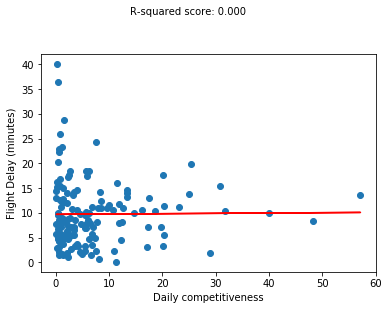

In [72]:
fig, ax1 = plt.subplots(1, 1)

comp = dataset.groupby(["Origin","UniqueCarrier"])[["DepDelay","Compet_daily"]].mean()
ax1.scatter(comp.Compet_daily, comp.DepDelay)
X = comp.Compet_daily.values.reshape(-1,1)
linreg = LinearRegression().fit(X, comp.DepDelay)
ax1.plot(comp.Compet_daily, linreg.coef_ * comp.Compet_daily + linreg.intercept_, 'r-')
ax1.text(14,50,'R-squared score: {:.3f}'
     .format(linreg.score(X, comp.DepDelay)))
ax1.set_xlabel('Daily competitiveness')
ax1.set_ylabel('Flight Delay (minutes)')

Text(0, 0.5, 'Flight Delay (minutes)')

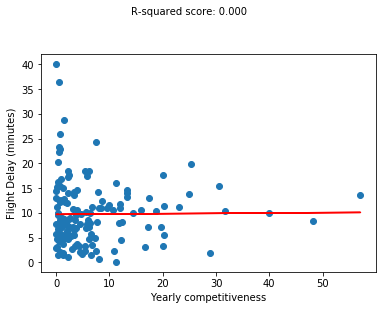

In [74]:
fig, ax1 = plt.subplots(1, 1)

comp = dataset.groupby(["Origin","UniqueCarrier"])[["DepDelay","Compet_yearly"]].mean()
ax1.scatter(comp.Compet_yearly, comp.DepDelay)
X = comp.Compet_yearly.values.reshape(-1,1)
linreg = LinearRegression().fit(X, comp.DepDelay)
ax1.plot(comp.Compet_yearly, linreg.coef_ * comp.Compet_yearly + linreg.intercept_, 'r-')
ax1.text(14,50,'R-squared score: {:.3f}'
     .format(linreg.score(X, comp.DepDelay)))
ax1.set_xlabel('Yearly competitiveness')
ax1.set_ylabel('Flight Delay (minutes)')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':


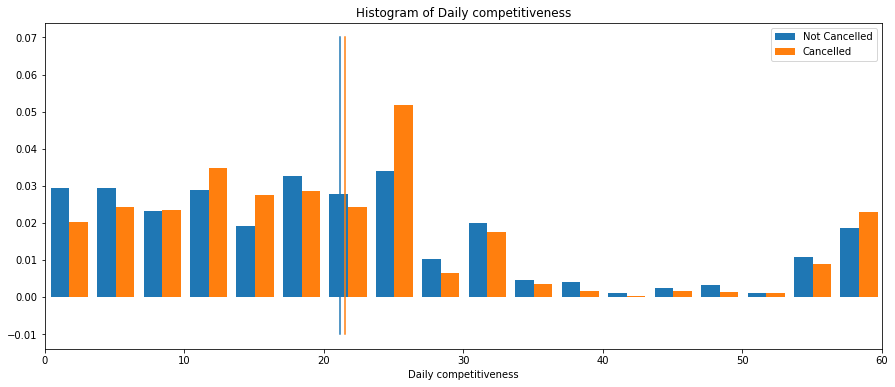

In [27]:
fig, ax = plt.subplots(figsize = (15,6))

x = dataset['Compet_daily'][dataset.Cancelled == 0]
y = dataset['Compet_daily'][dataset.Cancelled == 1]

x_mean = np.mean(x)
y_mean = np.mean(y)

ax.hist([x, y], normed=1, bins=30, label=['Not Cancelled', 'Cancelled'])
ax.plot([x_mean, x_mean],[-0.01,0.07],color='#1f77b4')
ax.plot([y_mean, y_mean],[-0.01,0.07],color='#ff7f0e')

ax.set_xlim(0,60)
ax.set_xlabel('Daily competitiveness')
ax.set_title('Histogram of Daily competitiveness')

plt.legend()
plt.show()

### Departure Time
* The most cancellations are clustered during the afternoon.
* By plotting the histograms for each airport, we found different behaviors in cancellations by departure time. Although, many of them have more cancellations during the afternoon. 
* We might need to use interaction variables in our regression models.
* To capture differences between different times of the day, we may need to bin departure time to less categories.

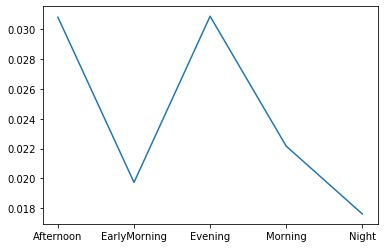

In [102]:
plt.plot(dataset.groupby(["DepTime_bins"])["Cancelled"].mean())

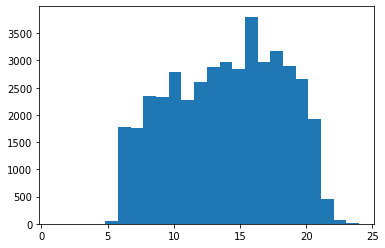

In [106]:
num_bins = 24
n, bins, patches = plt.hist(dataset['CRSDepTime'][dataset.Cancelled == 1], num_bins, alpha=1)
plt.show()

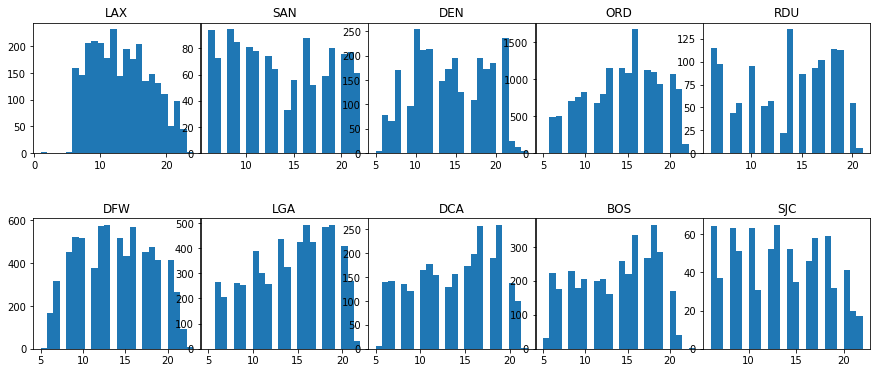

In [29]:
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i, airport in zip(range(10),list(set(dataset.Origin))):
    axs[i].hist(dataset['CRSDepTime_x'][(dataset.Cancelled == 1) & (dataset.Origin == airport)], num_bins)
    axs[i].set_title(airport)

### Cancellation code
* MQ presents high percentage of cancellations due to the weather and NAS in relation to the other airlines.
* F9 also has high percentage of cancellations due to the weather.
* It will be interesting to study the reasons behind that. We will study the effect of airports on weather cancellations to determine whether they are responsible for those cancellations.
* Also it would be interesting to find whether NAS related cancellations are also correlated with weather.

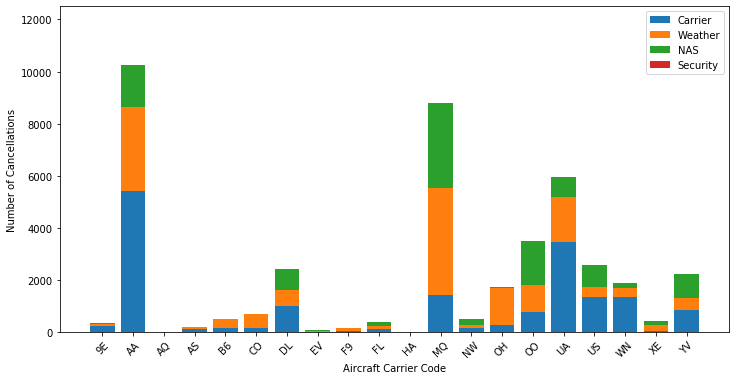

In [30]:
cancelled_group = dataset[dataset.Cancelled == 1].groupby(['UniqueCarrier','CancellationCode']).size().reindex(fill_value=0.0).unstack()
cg = cancelled_group.fillna(0)

b_bottom = cg.loc[:,'A'].values
c_bottom = b_bottom + cg.loc[:,'B'].values
d_bottom = c_bottom + cg.loc[:,'B'].values

x = cg.loc[:,'A'].index.values

fig, ax = plt.subplots(figsize = (12,6))

ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x, rotation = 45)
ax.bar(np.arange(len(x)),cg.loc[:,'A'].values, align='center', label='Carrier')
ax.bar(np.arange(len(x)),cg.loc[:,'B'].values, align='center', bottom=b_bottom, label='Weather')
ax.bar(np.arange(len(x)),cg.loc[:,'C'].values, align='center', bottom=c_bottom, label='NAS')
ax.bar(np.arange(len(x)),cancelled_group.loc[:,'D'].values, align='center', bottom=d_bottom, label='Security')

ax.set_xlabel('Aircraft Carrier Code')
ax.set_ylabel('Number of Cancellations')

plt.legend()
plt.show()

In [31]:
canc_code_airline = dataset[dataset.Cancelled == 1].groupby(["UniqueCarrier","CancellationCode"]).size().reset_index()
canc_airline = dataset[dataset.Cancelled == 1].groupby(["UniqueCarrier"]).size().reset_index()
canc_code_airline = canc_code_airline.merge(canc_airline, left_on=["UniqueCarrier"], right_on =["UniqueCarrier"], how = 'left')

canc_code_airline["perc"] = canc_code_airline["0_x"]/canc_code_airline["0_y"]

print(canc_code_airline[canc_code_airline.UniqueCarrier=="MQ"])
print(canc_code_airline[canc_code_airline.UniqueCarrier=="F9"])

   UniqueCarrier CancellationCode   0_x   0_y      perc
30            MQ                A  1435  8798  0.163105
31            MQ                B  4103  8798  0.466356
32            MQ                C  3258  8798  0.370311
33            MQ                D     2  8798  0.000227
   UniqueCarrier CancellationCode  0_x  0_y      perc
23            F9                A   54  162  0.333333
24            F9                B  107  162  0.660494
25            F9                C    1  162  0.006173


In [32]:
total = dataset[dataset.Cancelled == 1].groupby("CancellationCode").size().sum()
print("Carrier: ",17162/total)
print("Weather: ",14910/total)
print("NAS: ",10743/total)
print("Security: ",3/total)

Carrier:  0.4009063726406279
Weather:  0.34829938329284243
NAS:  0.2509577649037563
Security:  7.008035881143711e-05


## Taxi Out Analysis
* Taxi out time might be useful for modelling as it was found correlated with both airline and airport average delay time and percentage of cancellations
* After groupping the taxi out time by airport, carrier and departure time, it was found that it has higher correlation with departure delay than the original Taxi out feature.

In [33]:
dataset = dataset.rename(columns = {'TaxiOut_x':'TaxiOut',"CRSDepTime_x":"CRSDepTime"})

In [34]:
carrier_flights = dataset['UniqueCarrier'].groupby(dataset['UniqueCarrier']).count()
carrier_cancelled = dataset['Cancelled'].groupby(dataset['UniqueCarrier']).sum()
carrier_delayed = dataset[dataset.DepDelay.isna() == False]['UniqueCarrier'].groupby(dataset[dataset.DepDelay.isna() == False]['UniqueCarrier']).count()
carrier_avg_time = dataset['CRSElapsedTime'].groupby(dataset['UniqueCarrier']).mean()
carrier_avg_dist = dataset['Distance'].groupby(dataset['UniqueCarrier']).mean()
carrier_avg_delay = dataset['DepDelay'].groupby(dataset['UniqueCarrier']).mean()
carrier_avg_taxiOut = dataset['TaxiOut'].groupby(dataset['UniqueCarrier']).mean()
carrier_pct_cancelled = 100*np.divide(carrier_cancelled, carrier_flights)

summary_table_carrier = pd.concat([ carrier_flights, carrier_cancelled, carrier_pct_cancelled, 
                           carrier_avg_time, carrier_avg_dist, carrier_avg_delay, carrier_avg_taxiOut], axis=1)

summary_table_carrier.columns = [ 'Total Flights', 'Cancelled Flights', 'Percent Cancelled', 'Average Flight Time (minutes)',
                         'Average Flight Distance (miles)', 'Average Flight Delay (minutes)',  'Average Taxi-Out (minutes)']

Text(0, 0.5, 'Percent Cancelled')

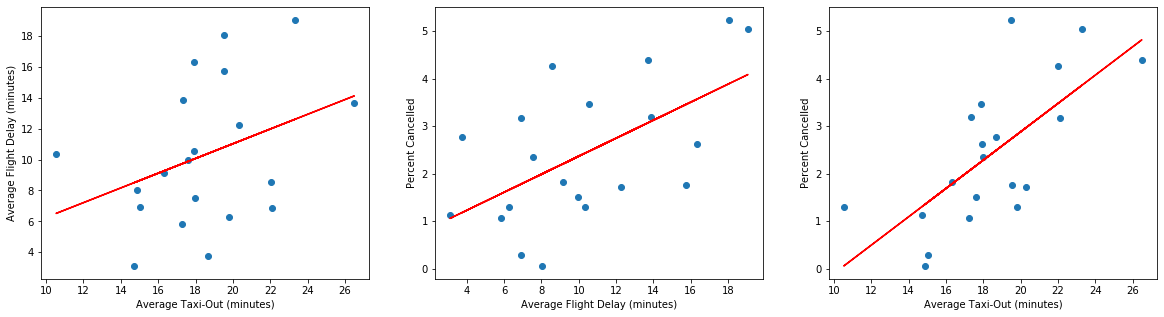

In [35]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

#Plot 1
ax1.scatter(carrier_avg_taxiOut, carrier_avg_delay)
X = carrier_avg_taxiOut.values.reshape(-1,1)
linreg = LinearRegression().fit(X, carrier_avg_delay)
ax1.plot(carrier_avg_taxiOut, linreg.coef_ * carrier_avg_taxiOut + linreg.intercept_, 'r-')
ax1.set_xlabel('Average Taxi-Out (minutes)')
ax1.set_ylabel('Average Flight Delay (minutes)')

#Plot 2
X = summary_table_carrier['Average Flight Delay (minutes)']
y = summary_table_carrier['Percent Cancelled']
ax2.scatter(X, y)

X = X.values.reshape(-1,1)

linreg = LinearRegression().fit(X, y)
ax2.plot(X, linreg.coef_ * X + linreg.intercept_, 'r-')
ax2.set_xlabel('Average Flight Delay (minutes)')
ax2.set_ylabel('Percent Cancelled')

#Plot 3
X = summary_table_carrier['Average Taxi-Out (minutes)']
y = summary_table_carrier['Percent Cancelled']
ax3.scatter(X, y)

X = X.values.reshape(-1,1)

linreg = LinearRegression().fit(X, y)
ax3.plot(X, linreg.coef_ * X + linreg.intercept_, 'r-')
ax3.set_xlabel('Average Taxi-Out (minutes)')
ax3.set_ylabel('Percent Cancelled')

In [36]:
carrier_flights = dataset['Origin'].groupby(dataset['Origin']).count()
carrier_cancelled = dataset['Cancelled'].groupby(dataset['Origin']).sum()
carrier_delayed = dataset[dataset.DepDelay.isna() == False]['Origin'].groupby(dataset[dataset.DepDelay.isna() == False]['Origin']).count()
carrier_avg_time = dataset['CRSElapsedTime'].groupby(dataset['Origin']).mean()
carrier_avg_dist = dataset['Distance'].groupby(dataset['Origin']).mean()
carrier_avg_delay = dataset['DepDelay'].groupby(dataset['Origin']).mean()
carrier_avg_taxiOut = dataset['TaxiOut'].groupby(dataset['Origin']).mean()
carrier_pct_cancelled = 100*np.divide(carrier_cancelled, carrier_flights)

summary_table_carrier = pd.concat([ carrier_flights, carrier_cancelled, carrier_pct_cancelled, 
                           carrier_avg_time, carrier_avg_dist, carrier_avg_delay, carrier_avg_taxiOut], axis=1)

summary_table_carrier.columns = [ 'Total Flights', 'Cancelled Flights', 'Percent Cancelled', 'Average Flight Time (minutes)',
                         'Average Flight Distance (miles)', 'Average Flight Delay (minutes)',  'Average Taxi-Out (minutes)']

Text(0, 0.5, 'Percent Cancelled')

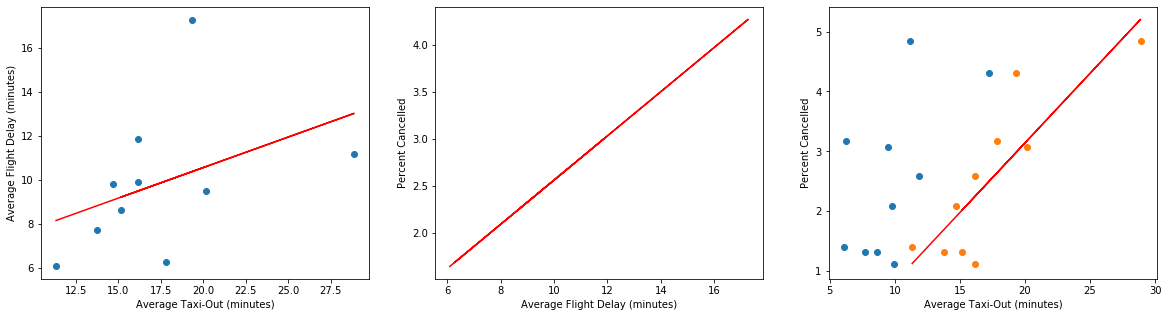

In [37]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))


#Plot 1
ax1.scatter(carrier_avg_taxiOut, carrier_avg_delay)
X = carrier_avg_taxiOut.values.reshape(-1,1)
linreg = LinearRegression().fit(X, carrier_avg_delay)
ax1.plot(carrier_avg_taxiOut, linreg.coef_ * carrier_avg_taxiOut + linreg.intercept_, 'r-')
ax1.set_xlabel('Average Taxi-Out (minutes)')
ax1.set_ylabel('Average Flight Delay (minutes)')

#Plot 2
X = summary_table_carrier['Average Flight Delay (minutes)']
y = summary_table_carrier['Percent Cancelled']
ax3.scatter(X, y)

X = X.values.reshape(-1,1)

linreg = LinearRegression().fit(X, y)
ax2.plot(X, linreg.coef_ * X + linreg.intercept_, 'r-')
ax2.set_xlabel('Average Flight Delay (minutes)')
ax2.set_ylabel('Percent Cancelled')

#Plot 3
X = summary_table_carrier['Average Taxi-Out (minutes)']
y = summary_table_carrier['Percent Cancelled']
ax3.scatter(X, y)

X = X.values.reshape(-1,1)

linreg = LinearRegression().fit(X, y)
ax3.plot(X, linreg.coef_ * X + linreg.intercept_, 'r-')
ax3.set_xlabel('Average Taxi-Out (minutes)')
ax3.set_ylabel('Percent Cancelled')


Text(0, 0.5, 'Average Flight Delay (minutes)')

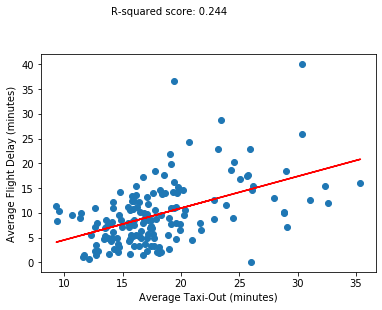

In [38]:
carrier_avg_delay = dataset[dataset.Cancelled==0].groupby(["Origin","UniqueCarrier"])['DepDelay'].mean()
carrier_avg_taxiOut = dataset[dataset.Cancelled==0].groupby(["Origin","UniqueCarrier"])['TaxiOut'].mean()

fig, ax1 = plt.subplots(1, 1)

ax1.scatter(carrier_avg_taxiOut, carrier_avg_delay)
X = carrier_avg_taxiOut.values.reshape(-1,1)
linreg = LinearRegression().fit(X, carrier_avg_delay)
ax1.plot(carrier_avg_taxiOut, linreg.coef_ * carrier_avg_taxiOut + linreg.intercept_, 'r-')
ax1.text(14,50,'R-squared score: {:.3f}'
     .format(linreg.score(X, carrier_avg_delay)))
ax1.set_xlabel('Average Taxi-Out (minutes)')
ax1.set_ylabel('Average Flight Delay (minutes)')

Text(0, 0.5, 'Average Flight Delay (minutes)')

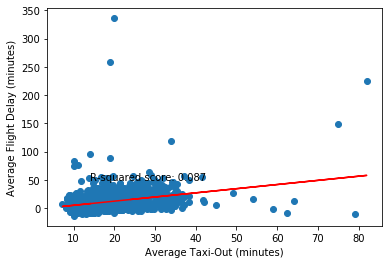

In [39]:
carrier_avg_delay = dataset[dataset.Cancelled==0].groupby(["Origin","UniqueCarrier","CRSDepTime"])['DepDelay'].mean()
carrier_avg_taxiOut = dataset[dataset.Cancelled==0].groupby(["Origin","UniqueCarrier","CRSDepTime"])['TaxiOut'].mean()

fig, ax1 = plt.subplots(1, 1)

ax1.scatter(carrier_avg_taxiOut, carrier_avg_delay)
X = carrier_avg_taxiOut.values.reshape(-1,1)
linreg = LinearRegression().fit(X, carrier_avg_delay)
ax1.plot(carrier_avg_taxiOut, linreg.coef_ * carrier_avg_taxiOut + linreg.intercept_, 'r-')
ax1.text(14,50,'R-squared score: {:.3f}'
     .format(linreg.score(X, carrier_avg_delay)))
ax1.set_xlabel('Average Taxi-Out (minutes)')
ax1.set_ylabel('Average Flight Delay (minutes)')

Text(0, 0.5, 'Flight Delay (minutes)')

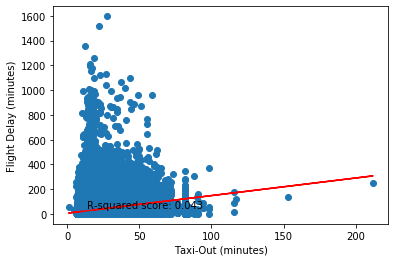

In [40]:
fig, ax1 = plt.subplots(1, 1)

ax1.scatter(dataset.TaxiOut_y[(dataset.Cancelled==0) & (dataset.DepDelay >0)], dataset.DepDelay[(dataset.Cancelled==0) & (dataset.DepDelay >0)])
X = dataset.TaxiOut_y[(dataset.Cancelled==0) & (dataset.DepDelay >0)].values.reshape(-1,1)
linreg = LinearRegression().fit(X, dataset.DepDelay[(dataset.Cancelled==0) & (dataset.DepDelay >0)])
ax1.plot(dataset.TaxiOut_y[(dataset.Cancelled==0) & (dataset.DepDelay >0)], linreg.coef_ * dataset.TaxiOut_y[(dataset.Cancelled==0) & (dataset.DepDelay >0)] + linreg.intercept_, 'r-')
ax1.text(14,50,'R-squared score: {:.3f}'
     .format(linreg.score(X, dataset.DepDelay[(dataset.Cancelled==0) & (dataset.DepDelay >0)])))
ax1.set_xlabel('Taxi-Out (minutes)')
ax1.set_ylabel('Flight Delay (minutes)')

Text(0, 0.5, 'Flight Delay (minutes)')

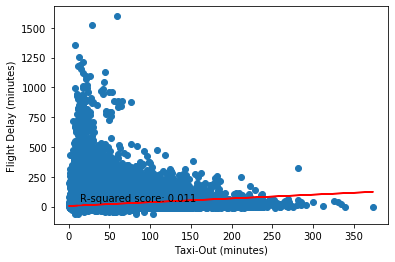

In [41]:
fig, ax1 = plt.subplots(1, 1)

ax1.scatter(dataset.TaxiOut[dataset.Cancelled==0], dataset.DepDelay[dataset.Cancelled==0])
X = dataset.TaxiOut[dataset.Cancelled==0].values.reshape(-1,1)
linreg = LinearRegression().fit(X, dataset.DepDelay[dataset.Cancelled==0])
ax1.plot(dataset.TaxiOut[dataset.Cancelled==0], linreg.coef_ * dataset.TaxiOut[dataset.Cancelled==0] + linreg.intercept_, 'r-')
ax1.text(14,50,'R-squared score: {:.3f}'
     .format(linreg.score(X, dataset.DepDelay[dataset.Cancelled==0])))
ax1.set_xlabel('Taxi-Out (minutes)')
ax1.set_ylabel('Flight Delay (minutes)')

### Weather

* 'mslp' and 'vsby' were dropped because they had many missing values
* The correlation plot shows slight negative correlation with tmpf, dwpf and alti, and positive correlation with sknt
* By plotting the average delay time and the percentage of cancellations vs. the 4 weather features we found relative associations that would be useful for building the models.

In [42]:
dataset = dataset[dataset["tmpf"].isna() == False]
dataset = dataset[dataset["dwpf"].isna() == False]
dataset = dataset[dataset["alti"].isna() == False]
dataset = dataset[dataset["sknt"].isna() == False]

In [43]:
dataset.tmpf = dataset.tmpf.astype(float)
dataset.dwpf = dataset.dwpf.astype(float)
dataset.alti = dataset.alti.astype(float)
dataset.sknt = dataset.sknt.astype(float)

In [44]:
corr = dataset[['DepDelay', 'tmpf', 'dwpf', 'sknt', 'alti']].corr()

          DepDelay      tmpf      dwpf      sknt      alti
DepDelay  1.000000 -0.032163 -0.009786  0.087316 -0.072922
tmpf     -0.032163  1.000000  0.877573 -0.054291 -0.310180
dwpf     -0.009786  0.877573  1.000000 -0.157907 -0.344659
sknt      0.087316 -0.054291 -0.157907  1.000000 -0.188308
alti     -0.072922 -0.310180 -0.344659 -0.188308  1.000000


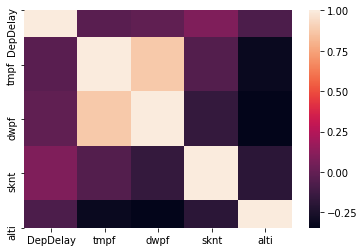

In [45]:
import seaborn as sns
print(corr)
sns.heatmap(corr)

In [46]:
origin_flights = dataset['Origin'].groupby(dataset['Origin']).count()
origin_cancelled = dataset['Cancelled'].groupby(dataset['Origin']).sum()
origin_delayed = dataset[dataset.DepDelay.isna() == False]['Origin'].groupby(dataset[dataset.DepDelay.isna() == False]['Origin']).count()
origin_avg_tmpf = dataset['tmpf'].groupby(dataset['Origin']).mean()
origin_avg_dwpf = dataset['dwpf'].groupby(dataset['Origin']).mean()
origin_avg_alti = dataset['alti'].groupby(dataset['Origin']).mean()
origin_avg_sknt = dataset['sknt'].groupby(dataset['Origin']).mean()
origin_avg_delay = dataset['DepDelay'].groupby(dataset['Origin']).mean()
carrier_pct_cancelled = 100*np.divide(origin_cancelled, origin_flights)

summary_table_origin = pd.concat([ origin_flights, carrier_pct_cancelled, origin_avg_delay,
                           origin_avg_tmpf, origin_avg_dwpf, origin_avg_alti, origin_avg_sknt], axis=1)

summary_table_origin.columns = [ 'Total Flights', 'Percent Cancelled','Average Delay', 'Average Temperature',
                         'Average dew point temperature', 'Average altidute',  'Average wind']

Text(0, 0.5, 'Average Flight Delay (minutes)')

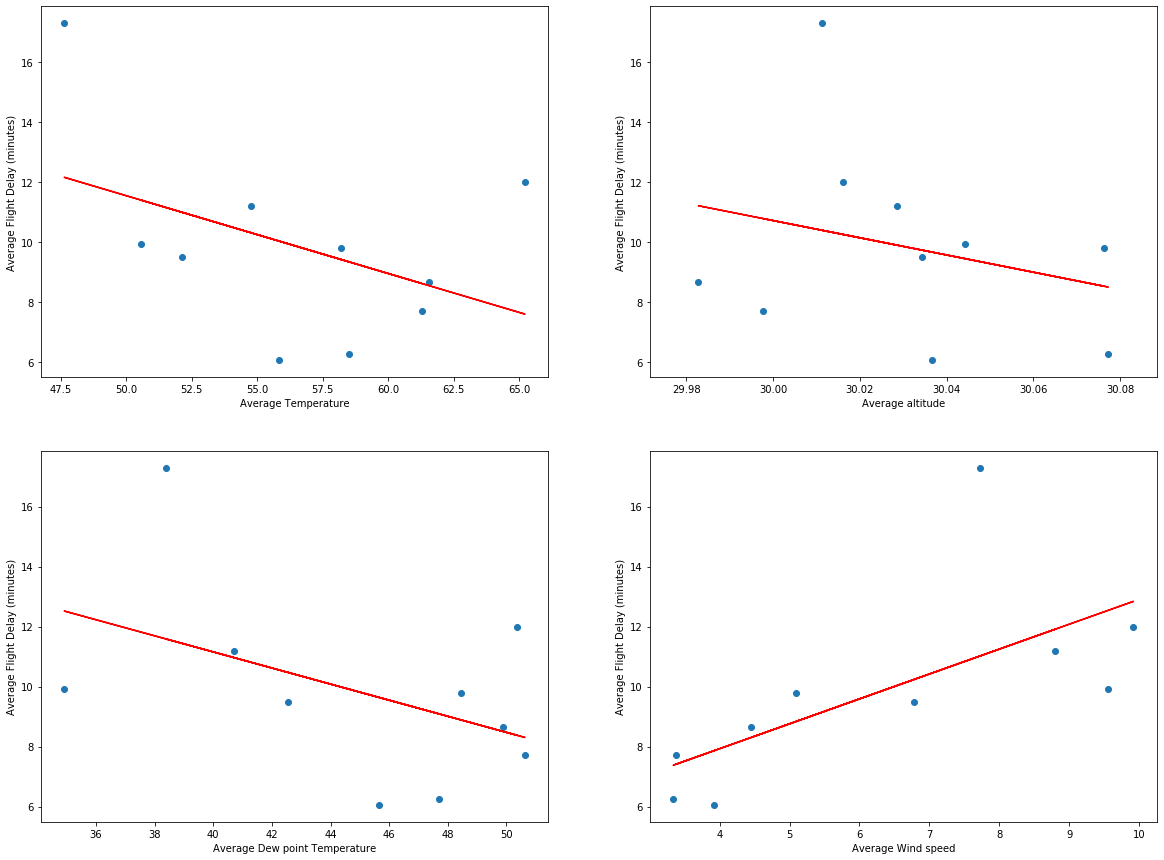

In [47]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize=(20, 15))

#origin_flights, carrier_pct_cancelled, origin_avg_delay,origin_avg_tmpf, origin_avg_dwpf, origin_avg_alti, origin_avg_sknt

X = summary_table_origin['Average Temperature']
y = summary_table_origin['Average Delay']
ax1.scatter(X, y)

X = X.values.reshape(-1,1)

linreg = LinearRegression().fit(X, y)
ax1.plot(X, linreg.coef_ * X + linreg.intercept_, 'r-')
ax1.set_xlabel('Average Temperature')
ax1.set_ylabel('Average Flight Delay (minutes)')

#Altitude
X = summary_table_origin['Average altidute']
y = summary_table_origin['Average Delay']
ax2.scatter(X, y)

X = X.values.reshape(-1,1)

linreg = LinearRegression().fit(X, y)
ax2.plot(X, linreg.coef_ * X + linreg.intercept_, 'r-')
ax2.set_xlabel('Average altitude')
ax2.set_ylabel('Average Flight Delay (minutes)')

#Dew point temperature

X = summary_table_origin['Average dew point temperature']
y = summary_table_origin['Average Delay']
ax3.scatter(X, y)

X = X.values.reshape(-1,1)

linreg = LinearRegression().fit(X, y)
ax3.plot(X, linreg.coef_ * X + linreg.intercept_, 'r-')
ax3.set_xlabel('Average Dew point Temperature')
ax3.set_ylabel('Average Flight Delay (minutes)')

#Wind

X = summary_table_origin['Average wind']
y = summary_table_origin['Average Delay']
ax4.scatter(X, y)

X = X.values.reshape(-1,1)

linreg = LinearRegression().fit(X, y)
ax4.plot(X, linreg.coef_ * X + linreg.intercept_, 'r-')
ax4.set_xlabel('Average Wind speed')
ax4.set_ylabel('Average Flight Delay (minutes)')


## Delay Reason

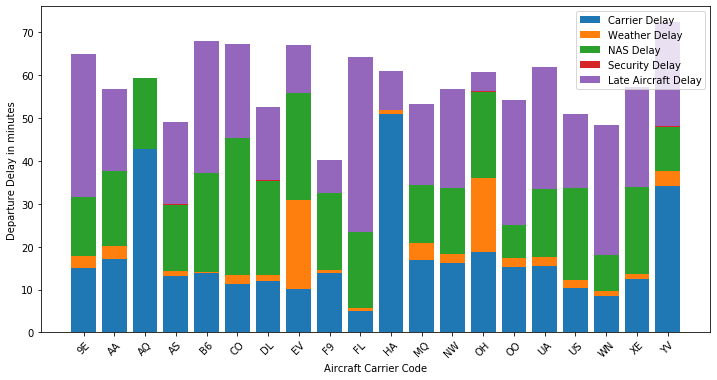

In [48]:
df = dataset.copy()
df['total_delay'] = (df['CarrierDelay'] + df['WeatherDelay']
             + df['NASDelay'] + df['SecurityDelay'] + df['LateAircraftDelay'])

df_delayed = df[~np.isnan(df['total_delay'])]
df['total_delay'].fillna(0, inplace=True)
df_delayed.head()

carrier_group = df_delayed['CarrierDelay'].groupby(df_delayed['UniqueCarrier']).mean()
weather_group = df_delayed['WeatherDelay'].groupby(df_delayed['UniqueCarrier']).mean()
nas_group = df_delayed['NASDelay'].groupby(df_delayed['UniqueCarrier']).mean()
security_group = df_delayed['SecurityDelay'].groupby(df_delayed['UniqueCarrier']).mean()
late_group = df_delayed['LateAircraftDelay'].groupby(df_delayed['UniqueCarrier']).mean()

w_bottom = carrier_group.values
n_bottom = w_bottom + weather_group.values
s_bottom = n_bottom + nas_group.values
l_bottom = s_bottom + security_group.values

x = carrier_group.index.values

fig, ax = plt.subplots(figsize = (12,6))

ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x, rotation = 45)
ax.bar(np.arange(len(x)),carrier_group.values, align='center', label='Carrier Delay')
ax.bar(np.arange(len(x)),weather_group.values, align='center', bottom=w_bottom, label='Weather Delay')
ax.bar(np.arange(len(x)),nas_group.values, align='center', bottom=n_bottom, label='NAS Delay')
ax.bar(np.arange(len(x)),security_group.values, align='center', bottom=s_bottom, label='Security Delay')
ax.bar(np.arange(len(x)),late_group.values, align='center', bottom=l_bottom, label='Late Aircraft Delay')

ax.set_xlabel('Aircraft Carrier Code')
ax.set_ylabel('Departure Delay in minutes')

plt.legend()
plt.show()

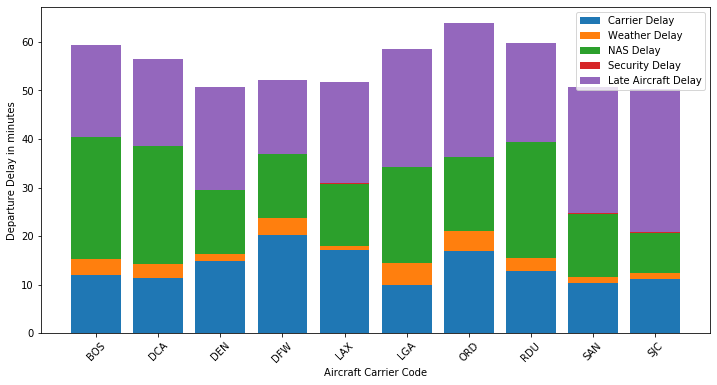

In [49]:
df['total_delay'] = (df['CarrierDelay'] + df['WeatherDelay'] + df['NASDelay'] + df['SecurityDelay'] + df['LateAircraftDelay'])

df_delayed = df[~np.isnan(df['total_delay'])]
df['total_delay'].fillna(0, inplace=True)
df_delayed.head()

carrier_group = df_delayed['CarrierDelay'].groupby(df_delayed['Origin']).mean()
weather_group = df_delayed['WeatherDelay'].groupby(df_delayed['Origin']).mean()
nas_group = df_delayed['NASDelay'].groupby(df_delayed['Origin']).mean()
security_group = df_delayed['SecurityDelay'].groupby(df_delayed['Origin']).mean()
late_group = df_delayed['LateAircraftDelay'].groupby(df_delayed['Origin']).mean()

w_bottom = carrier_group.values
n_bottom = w_bottom + weather_group.values
s_bottom = n_bottom + nas_group.values
l_bottom = s_bottom + security_group.values

x = carrier_group.index.values

fig, ax = plt.subplots(figsize = (12,6))

ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x, rotation = 45)
ax.bar(np.arange(len(x)),carrier_group.values, align='center', label='Carrier Delay')
ax.bar(np.arange(len(x)),weather_group.values, align='center', bottom=w_bottom, label='Weather Delay')
ax.bar(np.arange(len(x)),nas_group.values, align='center', bottom=n_bottom, label='NAS Delay')
ax.bar(np.arange(len(x)),security_group.values, align='center', bottom=s_bottom, label='Security Delay')
ax.bar(np.arange(len(x)),late_group.values, align='center', bottom=l_bottom, label='Late Aircraft Delay')

ax.set_xlabel('Aircraft Carrier Code')
ax.set_ylabel('Departure Delay in minutes')

plt.legend()
plt.show()

In [50]:
def bin_month(month):
    if month in [12,1,2]:
        return "Winter"
    elif month in [3,4,5]:
        return "Spring"
    elif month in [6,7,8]:
        return "Summer"
    else:
        return "Autumn"
    
dataset["Month_bins"] = dataset.Month.map(bin_month)

In [88]:
def bin_deptime(time):
    if time in [4,5,6,7]:
        return "EarlyMorning"
    elif time in [8,9,10,11]:
        return "Morning"
    elif time in [12,13,14,15,16,17]:
        return "Afternoon"
    elif time in [18,19,20,21]:
        return "Evening"
    else:
        return "Night"
    
dataset["DepTime_bins"] = dataset.CRSDepTime.map(bin_deptime)

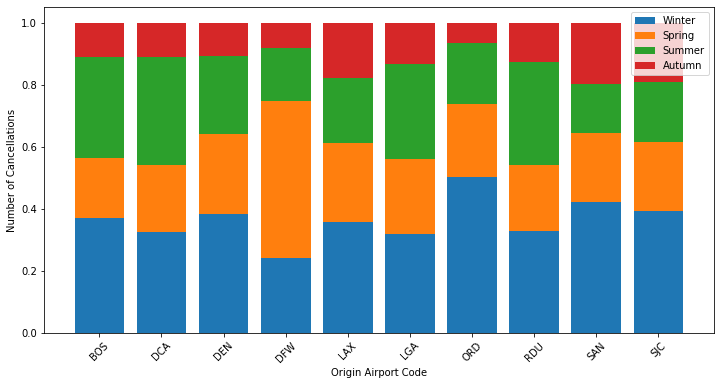

In [75]:
cancelled_group = dataset[dataset.Cancelled == 1].groupby(['Origin','Month_bins']).size().reindex(fill_value=0.0).unstack()
cancelled_group = cancelled_group.replace({np.nan:0})
cancelled_group["total"] = cancelled_group["Winter"]+cancelled_group["Spring"]+cancelled_group["Summer"]+cancelled_group["Autumn"]
cancelled_group.Winter = cancelled_group.Winter/cancelled_group.total
cancelled_group.Spring = cancelled_group.Spring/cancelled_group.total
cancelled_group.Summer = cancelled_group.Summer/cancelled_group.total
cancelled_group.Autumn = cancelled_group.Autumn/cancelled_group.total

cg = cancelled_group.fillna(0)

b_bottom = cg.loc[:,'Winter'].values
c_bottom = b_bottom + cg.loc[:,'Spring'].values
d_bottom = c_bottom + cg.loc[:,'Summer'].values
e_bottom = d_bottom + cg.loc[:,'Autumn'].values

x = cg.loc[:,'Winter'].index.values

fig, ax = plt.subplots(figsize = (12,6))

ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x, rotation = 45)
ax.bar(np.arange(len(x)),cg.loc[:,'Winter'].values, align='center', label='Winter')
ax.bar(np.arange(len(x)),cg.loc[:,'Spring'].values, align='center', bottom=b_bottom, label='Spring')
ax.bar(np.arange(len(x)),cg.loc[:,'Summer'].values, align='center', bottom=c_bottom, label='Summer')
ax.bar(np.arange(len(x)),cancelled_group.loc[:,'Autumn'].values, align='center', bottom=d_bottom, label='Autumn')

ax.set_xlabel('Origin Airport Code')
ax.set_ylabel('Number of Cancellations')

plt.legend()
plt.show()

DepTime_bins  Afternoon  EarlyMorning   Evening   Morning     Night    total
Origin                                                                      
BOS            0.407052      0.121580  0.242595  0.228491  0.000282   3545.0
DCA            0.405375      0.108251  0.259273  0.226344  0.000757   2642.0
DEN            0.359626      0.055327  0.295327  0.273645  0.016075   2675.0
DFW            0.431930      0.068215  0.223104  0.262331  0.014422   6934.0
LAX            0.390025      0.110872  0.158235  0.287765  0.053104   2787.0
LGA            0.412884      0.082402  0.288757  0.210545  0.005412   5728.0
ORD            0.464186      0.066303  0.263813  0.197510  0.008188  15022.0
RDU            0.399839      0.170555  0.231698  0.197908  0.000000   1243.0
SAN            0.299347      0.136215  0.238173  0.276509  0.049755   1226.0
SJC            0.389527      0.128991  0.194125  0.265645  0.021711    783.0


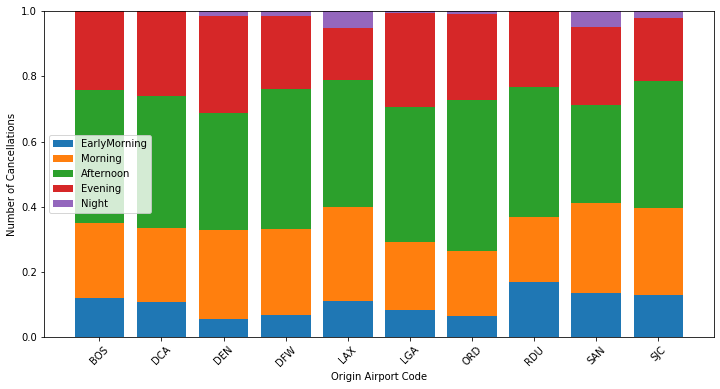

In [99]:
cancelled_group = dataset[dataset.Cancelled == 1].groupby(['Origin','DepTime_bins']).size().reindex(fill_value=0.0).unstack()
cancelled_group = cancelled_group.replace({np.nan:0})
cancelled_group["total"] =cancelled_group["EarlyMorning"]+ cancelled_group["Afternoon"]+cancelled_group["Evening"]+cancelled_group["Morning"]+cancelled_group["Night"]
cancelled_group.Afternoon = cancelled_group.Afternoon/cancelled_group.total
cancelled_group.Morning = cancelled_group.Morning/cancelled_group.total
cancelled_group.Night = cancelled_group.Night/cancelled_group.total
cancelled_group.Evening = cancelled_group.Evening/cancelled_group.total
cancelled_group["EarlyMorning"] = cancelled_group["EarlyMorning"]/cancelled_group.total

cg = cancelled_group.fillna(0)

a_bottom = cg.loc[:,'EarlyMorning'].values
b_bottom = a_bottom + cg.loc[:,'Morning'].values
c_bottom = b_bottom + cg.loc[:,'Afternoon'].values
d_bottom = c_bottom + cg.loc[:,'Evening'].values
e_bottom = d_bottom + cg.loc[:,'Night'].values
print(cg)

x = cg.loc[:,'EarlyMorning'].index.values

fig, ax = plt.subplots(figsize = (12,6))

ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x, rotation = 45)
ax.bar(np.arange(len(x)),cg.loc[:,'EarlyMorning'].values, align='center', label='EarlyMorning')
ax.bar(np.arange(len(x)),cg.loc[:,'Morning'].values, align='center', bottom=a_bottom, label='Morning')
ax.bar(np.arange(len(x)),cg.loc[:,'Afternoon'].values, align='center', bottom=b_bottom, label='Afternoon')
ax.bar(np.arange(len(x)),cg.loc[:,'Evening'].values, align='center', bottom=c_bottom, label='Evening')
ax.bar(np.arange(len(x)),cg.loc[:,'Night'].values, align='center', bottom=d_bottom, label='Night')

ax.set_xlabel('Origin Airport Code')
ax.set_ylabel('Number of Cancellations')

plt.legend()
plt.show()

### Bin DayOfMonth into 5-day categories

In [54]:
cat = []
for i in dataset.DayofMonth:
    if i<6:
        cat.append(1)
    elif i<11:
        cat.append(2)
    elif i<16:
        cat.append(3)
    elif i<21:
        cat.append(4)
    elif i<26:
        cat.append(5)
    else:
        cat.append(6)
        
cat = pd.DataFrame(cat)
cat = cat.set_index(dataset.index.values)
dataset["DayOfMonthCategories"] = cat

In [55]:
dataset = dataset.drop("DayofMonth", axis=1)
dataset.head()

,Month,TaxiOut,DayOfWeek,CancellationCode,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,...,diff,CRSElapsedTime,Compet_daily,Compet_yearly,Avg_Delay_4hours,TaxiOut_y,DepDelay_y,Month_bins,DepTime_bins,DayOfMonthCategories
0,1,10.0,4,NaN,17.0,20.0,WN,230,15.0,25.0,...,245,105.0,18.484848,20.18184,10.953488,9.677966,32.025424,Winter,Afternoon,1
1,1,9.0,4,NaN,20.0,23.0,WN,361,32.0,40.0,...,285,105.0,18.484848,20.18184,22.777778,9.677966,32.025424,Winter,Evening,1
2,1,5.0,4,NaN,13.0,16.0,WN,397,11.0,13.0,...,285,105.0,18.484848,20.18184,8.921053,9.677966,32.025424,Winter,Afternoon,1
3,1,8.0,4,NaN,9.0,12.0,WN,3245,-7.0,4.0,...,285,105.0,18.484848,20.18184,3.000000,9.677966,32.025424,Winter,Morning,1
4,1,7.0,4,NaN,10.0,15.0,WN,304,-1.0,9.0,...,490,170.0,18.484848,20.18184,-0.282609,9.677966,32.025424,Winter,Morning,1


In [56]:
dataset.to_csv("cleaned2.csv")